In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
import pandas as pd

rng = np.random.RandomState(42)
covid_datasets_dir = Path('covid-datasets')
print('Done!')

Done!


## Loading in and filtering Cohen data

In [23]:
cohen_covid_md = pd.read_csv(str(Path('covid-datasets/covid-chestxray-dataset/metadata.csv')))
# Removes all non-covid and non-X-Ray data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['modality'] == 'X-ray') & (cohen_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
cohen_covid_md = cohen_covid_md.drop_duplicates('patientid', keep='first')
print(f'Total Unique Patient COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Removes all AP Supine or Lateral X-rays (keeps only PA or AP images)
cohen_covid_md = cohen_covid_md[(cohen_covid_md['view']=='PA') | (cohen_covid_md['view']=='PA')]
print(f'Total Unique Patient COVID-19 PA or AP X-Rays: {cohen_covid_md.shape[0]}')

Total COVID-19 X-Rays: 446
Total Unique Patient COVID-19 X-Rays: 259
Total Unique Patient COVID-19 PA or AP X-Rays: 137


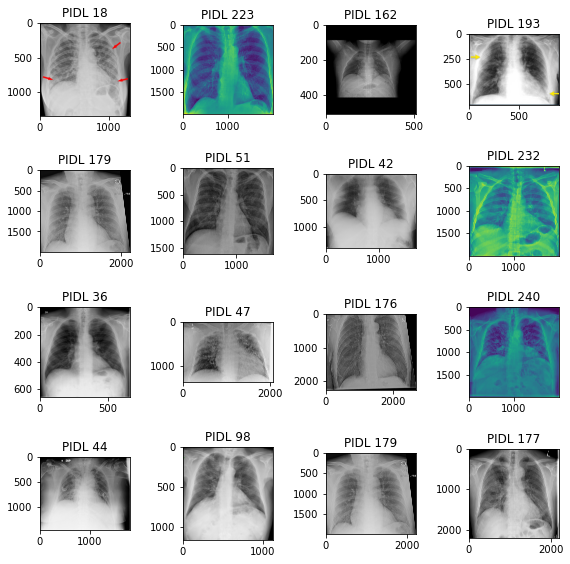

In [33]:
cohen_image_dir = covid_datasets_dir / 'covid-chestxray-dataset' / 'images'
# gets a list of all .png and .jpg images in cohen dataset
# cohen_image_paths = sorted(list(cohen_image_paths.glob('**/*.png')) + list(cohen_image_paths.glob('**/*.jpg')))


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
for ax in axes.ravel():
    xray_sample = cohen_covid_md.sample()
    image = plt.imread(str(cohen_image_dir / xray_sample['filename'].values[0]))
    ax.imshow(image)
    ax.set_title(f"PIDb {xray_sample['patientid'].values[0]}")
plt.tight_layout()
plt.show()

# Loading in and filtering Figure 1 Covid Data

In [ ]:
Fig_covid_md = pd.read_csv(str(Path('covid-datasets/Figure1-COVID-chestxray-dataset/metadata.csv')))
# Removes all non-covid and non-X-Ray data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['modality'] == 'X-ray') & (cohen_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
cohen_covid_md = cohen_covid_md.drop_duplicates('patientid', keep='first')
print(f'Total Unique Patient COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Removes all AP Supine or Lateral X-rays (keeps only PA or AP images)
cohen_covid_md = cohen_covid_md[(cohen_covid_md['view']=='PA') | (cohen_covid_md['view']=='PA')]
print(f'Total Unique Patient COVID-19 PA or AP X-Rays: {cohen_covid_md.shape[0]}')

In [40]:
fig_covid_md = pd.read_csv(str(Path('covid-datasets/Figure1-COVID-chestxray-dataset/metadata.csv')))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 31: invalid start byte

In [76]:
fig_covid_md = pd.read_csv(str(covid_datasets_dir / 'Figure1-COVID-chestxray-dataset'/ 'metadata.csv'), encoding= 'unicode_escape', index_col='patientid')
# Removes all non-covid and non-X-Ray data from dataframe
fig_covid_md  = fig_covid_md[(fig_covid_md['modality'] == 'X-ray') & (fig_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 X-Rays: {fig_covid_md.shape[0]}')

# Getting unique patient ids
pat_ids = list(fig_covid_md.index.values)
unique_names = []
for name in pat_ids:
    split_name = name.split('-')[-1]
    if split_name.isdigit():
        repeated_flag = 0
        unique_names.append(name)
    else:  # if repeated it has an alpha value after the numeric id
        if repeated_flag == 0:
            unique_names.append(name)
            repeated_flag = 1

            

Total COVID-19 X-Rays: 35


In [78]:
fig_covid_md.loc[unique_names[0]]

offset                                                                 13
sex                                                                     M
age                                                                    33
finding                                                          COVID-19
survival                                                              NaN
temperature                                                           NaN
pO2 saturation                                                         58
view                                                             AP erect
modality                                                            X-ray
artifacts/distortion                                                  NaN
notes                   O2 saturation was initially 58% on room air an...
Name: COVID-00001, dtype: object

In [68]:
test = pd.read_csv(str(covid_datasets_dir / 'Figure1-COVID-chestxray-dataset'/ 'metadata.csv'), encoding= 'unicode_escape', index_col='patientid')
test['patientid'
    ]

KeyError: 'patientid'

In [54]:
test = 'COVID-00043b'
test.split('-')

['COVID00043b']

In [58]:
test = '1234a'
test.isdigit()

False

In [ ]:
Fig1_image_dir = covid_datasets_dir / 'Figure1-COVID-chestxray-dataset' / 'images'
